# Environment Setup

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
from unsloth import FastLanguageModel
import torch

fourbit_models = [
    "unsloth/Qwen3-1.7B-unsloth-bnb-4bit", # Qwen 14B 2x faster
    "unsloth/Qwen3-4B-unsloth-bnb-4bit",
    "unsloth/Qwen3-8B-unsloth-bnb-4bit",
    "unsloth/Qwen3-14B-unsloth-bnb-4bit",
    "unsloth/Qwen3-32B-unsloth-bnb-4bit",

    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/Phi-4",
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/orpheus-3b-0.1-ft-unsloth-bnb-4bit" # [NEW] We support TTS models!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B",
    max_seq_length = 2048,   # Context length - can be longer, but uses more memory
    load_in_4bit = True,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning = False, # We have full finetuning now!
    # token = "hf_...",      # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.12: Fast Qwen3 patching. Transformers: 4.53.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,           # Choose any number > 0! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,  # Best to choose alpha = rank or rank*2
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,   # We support rank stabilized LoRA
    loftq_config = None,  # And LoftQ
)

Unsloth 2025.6.12 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re

df_train = pd.read_csv("/content/dataset/train.csv")
df_test = pd.read_csv("/content/dataset/test.csv")

/tmp/ipython-input-5-728472055.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_test, x='subdomain', order=df_test['subdomain'].value_counts().index, palette="Set2")


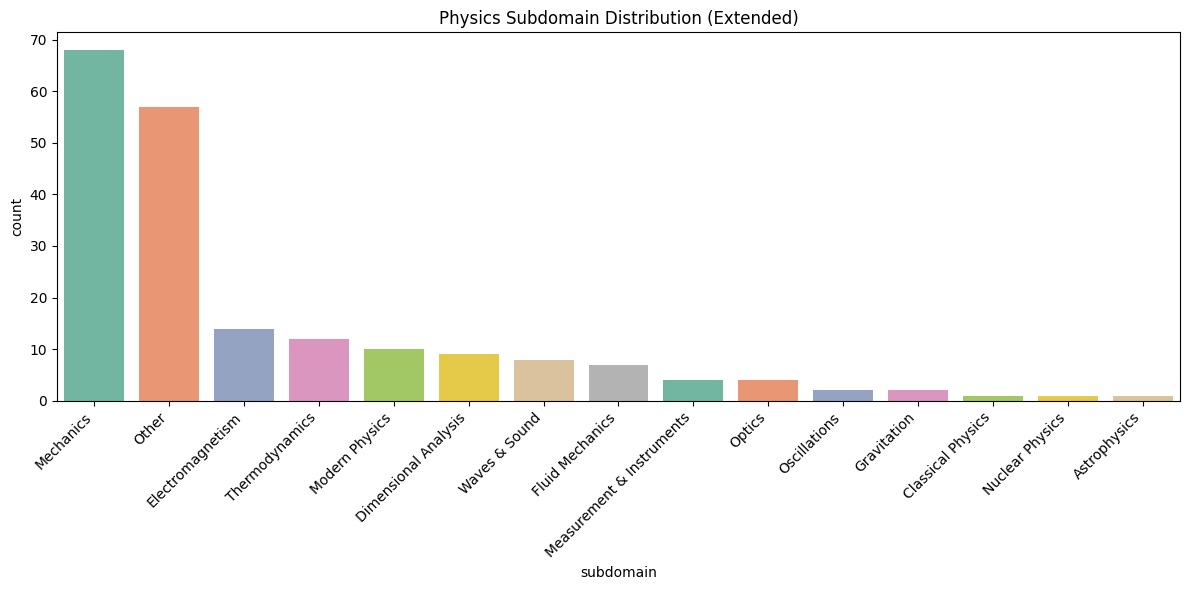

In [ ]:
physics_subdomains = {
    'Mechanics': [
        'গতি', 'বল', 'ভর', 'ত্বরণ', 'নিউটনের', 'সরণ', 'নিয়ম', 'দ্রুতি', 'ঘর্ষণ', 'কাজ', 'শক্তি', 'পদার্থের গতি',
        'কণার গতি', 'গতিশক্তি', 'বস্তু', 'ভরবেগ', 'নিয়মাবলি'
    ],
    'Thermodynamics': [
        'তাপ', 'তাপগতিবিদ্যা', 'উষ্ণতা', 'তাপমাত্রা', 'তাপ পরিবহণ', 'বাষ্পীভবন', 'তাপবিনিময়', 'তাপীয়', 'তাপ শক্তি',
        'তাপগতির সূত্র', 'গলন', 'বাষ্প চাপ', 'বর্জ্য তাপ'
    ],
    'Optics': [
        'আলোক', 'প্রতিফলন', 'প্রতিসরণ', 'লেন্স', 'আবরণ', 'আলোকবর্ষ', 'আলোর গতি', 'আলোক তরঙ্গ', 'আবদ্ধতা',
        'আয়না', 'আলোক রশ্মি', 'বিভব পার্থক্য'
    ],
    'Electromagnetism': [
        'বিদ্যুৎ', 'চুম্বকত্ব', 'কারেন্ট', 'রোধ', 'বৈদ্যুতিক', 'ভোল্টেজ', 'আম্পিয়ার', 'রেজিস্ট্যান্স', 'সার্কিট',
        'ফারাডে', 'ইলেকট্রোম্যাগনেটিক', 'ক্যাপাসিট্যান্স', 'ফ্লাক্স', 'ইন্ডাকশন'
    ],
    'Modern Physics': [
        'কোয়ান্টাম', 'তরঙ্গ', 'আণবিক', 'আপেক্ষিকতা', 'নিউক্লিয়াস', 'বস্তু-কণা', 'ফটোইলেকট্রিক', 'হাইজেনবার্গ',
        'বোস-আইনস্টাইন', 'ডি ব্রয়', 'শ্রোডিঞ্জার'
    ],
    'Waves & Sound': [
        'তরঙ্গ', 'শব্দ', 'কম্পন', 'আবৃত্তি', 'তরঙ্গদৈর্ঘ্য', 'ধ্বনি', 'তরঙ্গ গতি', 'অনুপাতিকতা', 'স্বর', 'আধান',
        'ডপলার প্রভাব', 'সুর', 'আধিক্য'
    ],
    'Nuclear Physics': [
        'পারমাণবিক', 'নিউক্লিয়াস', 'আয়ন', 'রেডিওএকটিভ', 'আধাজীবন', 'আণবিক শক্তি', 'বিজারণ', 'বিকিরণ', 'গামা রশ্মি',
        'নিউট্রন', 'প্রোটন', 'নিউক্লিয়ার বিক্রিয়া', 'পারমাণবিক সংখ্যা'
    ],
    'Electronics': [
        'ডায়োড', 'ট্রানজিস্টর', 'লজিক গেট', 'ইনপুট', 'আউটপুট', 'কম্পিউটার', 'সার্কিট', 'এন্ড গেট', 'অর গেট',
        'মাইক্রোচিপ', 'মাউস', 'বাফার', 'ফ্লিপ-ফ্লপ'
    ],
    'Astrophysics': [
        'তারা', 'গ্যালাক্সি', 'বিগ ব্যাং', 'ব্ল্যাক হোল', 'নক্ষত্র', 'মহাকর্ষ', 'বৃহস্পতি', 'মহাজাগতিক', 'মহাশূন্য',
        'বহির্বিশ্ব', 'কোসমোলজি', 'ধূমকেতু', 'ইভেন্ট হরাইজন'
    ],
    'Fluid Mechanics': [
        'পানি', 'প্রবাহ', 'চাপ', 'ধারণক্ষমতা', 'পৃষ্ঠটান', 'পাসকালের নীতি', 'বার্নুলির নীতি', 'আনুভূমিক প্রবাহ',
        'ভিসকসিটি', 'ফ্লুইড', 'ব্লেড', 'লিফট বল'
    ],
    'Oscillations': [
        'দোলন', 'স্পন্দন', 'সরল ছন্দিত', 'কম্পাঙ্ক', 'অম্প্লিচ্যুড', 'হারমোনিক', 'পিরিয়ডিক', 'কম্পাঙ্কের মান',
        'রেজোন্যান্স', 'ধ্বনিতরঙ্গ'
    ],
    'Gravitation': [
        'মহাকর্ষ', 'আকর্ষণ', 'ওজন', 'মহাকর্ষীয়', 'গ্রাভিটি', 'গ্রহ', 'উপগ্রহ', 'প্রত্যাহার বল', 'ক্ষয় বল',
        'কেন্দ্রমুখী বল'
    ],
    'Classical Physics': [
        'ক্লাসিকাল', 'গ্যালিলিও', 'নিউটনীয়', 'পুরাতন পদার্থবিজ্ঞান', 'বস্তুনিষ্ঠ', 'অবজারভেবল', 'অ্যারিস্টটল',
        'শ্রেণীবদ্ধ', 'গতি সংক্রান্ত সূত্র'
    ],
    'Relativity': [
        'আপেক্ষিকতা', 'বিশেষ আপেক্ষিকতা', 'সাধারণ আপেক্ষিকতা', 'সময় প্রসারণ', 'মাস-এনার্জি', 'আলোকগতি',
        'রেফারেন্স ফ্রেম', 'সমান্তরাল চলন', 'আইনস্টাইন'
    ],
    'Dimensional Analysis': [
        'মাত্রা', 'একক', 'মাত্রাবিশ্লেষণ', 'মাত্রিক রাশি', 'মাত্রার সূত্র', 'একক রূপান্তর', 'সীমা', 'ডাইমেনশন'
    ],
    'Measurement & Instruments': [
        'মাপ', 'পরিমাপ', 'ঘড়ি', 'স্কেল', 'স্টপওয়াচ', 'ইন্সট্রুমেন্ট', 'ক্যালিপার', 'স্ক্রু গজ', 'প্রেসিশন', 'ত্রুটি',
        'ভুল', 'পরিমাপ পদ্ধতি', 'যন্ত্র', 'নির্ভুলতা'
    ],
    'Other': []  # fallback
}

def classify_question(text):
    for domain, keywords in physics_subdomains.items():
        if any(keyword in text for keyword in keywords):
            return domain
    return 'Other'

df_test['subdomain'] = df_test['question'].apply(classify_question)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df_test, x='subdomain', order=df_test['subdomain'].value_counts().index, palette="Set2")
plt.title('Physics Subdomain Distribution (Extended)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Plot saved as 'question_distribution_comparison.png'


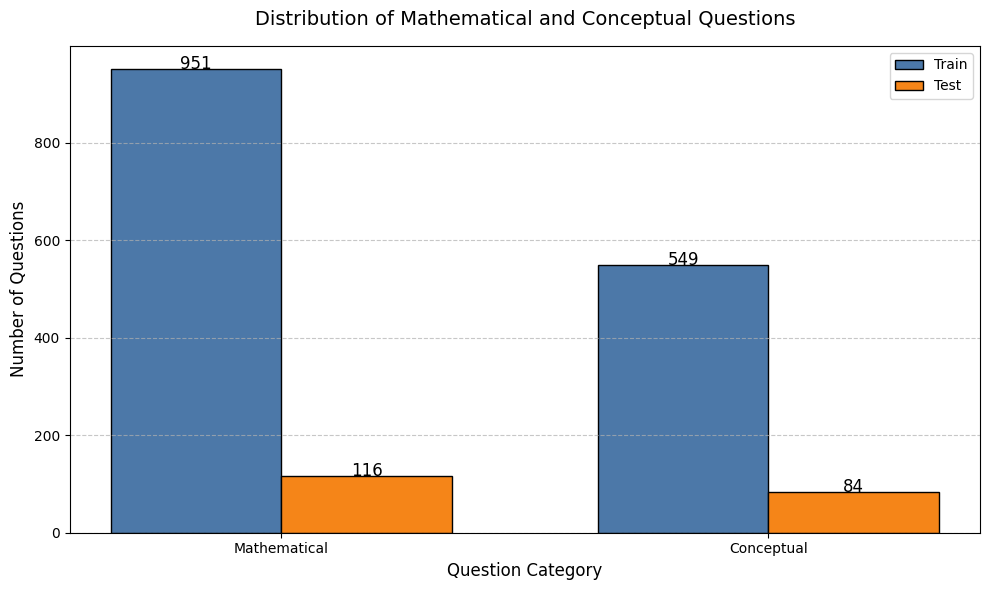

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

# Function to categorize a question based on its options
def categorize_question(options):
    # Check if options contain numerical values or physics units
    numerical_pattern = r'\d+\.?\d*|\d+\s*(J|m|N|s|kg|Hz|eV|ms−1|ms-1|ms-2|ms−2|Nm|K|°C|Wb|W|A|V|Pa|rad|Ω|MeV|Å|kW|kHz|MHz|cm|mm|μT|μC|Nm-2|N/m2)'
    # Remove square brackets and split options
    if not isinstance(options, str):
        return 'Conceptual'  # Handle non-string options
    options_clean = options.strip('[]').split("' '")
    options_clean = [opt.strip("'") for opt in options_clean if opt.strip("'")]

    # If any option contains a number or unit, it's mathematical
    for opt in options_clean:
        if re.search(numerical_pattern, opt):
            return 'Mathematical'
    return 'Conceptual'

# Function to process a CSV file and return category counts
def process_csv(file_path):
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Clean the data: remove rows with missing or invalid question/options
        df = df.dropna(subset=['question', 'options'])
        df = df[df['question'].str.strip() != '']
        df = df[df['options'].str.strip() != '']

        # Categorize each question
        df['category'] = df['options'].apply(categorize_question)

        # Count the number of questions in each category
        category_counts = df['category'].value_counts().to_dict()
        mathematical_count = category_counts.get('Mathematical', 0)
        conceptual_count = category_counts.get('Conceptual', 0)

        return mathematical_count, conceptual_count
    except FileNotFoundError:
        print(f"Error: '{file_path}' file not found in the current directory.")
        return 0, 0
    except Exception as e:
        print(f"An error occurred while processing '{file_path}': {str(e)}")
        return 0, 0

# Process both CSV files
train_math, train_conceptual = process_csv('/content/dataset/train.csv')
test_math, test_conceptual = process_csv('/content/dataset/test.csv')

# Prepare data for plotting
categories = ['Mathematical', 'Conceptual']
train_counts = [train_math, train_conceptual]
test_counts = [test_math, test_conceptual]

# Set up the plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(categories))

# Plot bars for train and test datasets
plt.bar(index, train_counts, bar_width, label='Train', color='#4C78A8', edgecolor='black')
plt.bar(index + bar_width, test_counts, bar_width, label='Test', color='#F58518', edgecolor='black')

# Customize the plot
plt.title('Distribution of Mathematical and Conceptual Questions', fontsize=14, pad=15)
plt.xlabel('Question Category', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.xticks(index + bar_width / 2, categories)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, count in enumerate(train_counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=12)
for i, count in enumerate(test_counts):
    plt.text(i + bar_width, count + 0.5, str(count), ha='center', fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('question_distribution_comparison.png', dpi=300)
print("Plot saved as 'question_distribution_comparison.png'")

# Display the plot
plt.show()

In [ ]:
def clean_text(text):
    """Clean text by converting to string, removing invalid characters, and stripping whitespace."""
    if not isinstance(text, str):
        text = str(text)
    text = ''.join(c for c in text if c.isprintable())
    text = re.sub(r'\s+', ' ', text).strip()
    return text if text else "Unknown"


In [ ]:
# df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
# df_test = df_test.sample(frac=0.1, random_state=42).reset_index(drop=True)
# df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)


def parse_options(x):
    print(f"Parsing options: {x}")
    options = []

    if isinstance(x, list):
        print(f"Input is already a list: {x}")
        options = x
    elif isinstance(x, str):
        print(f"Input is a string: {x}")
        cleaned = x.strip()
        if cleaned.startswith("[") and cleaned.endswith("]"):
            cleaned = cleaned[1:-1].strip()
            options = re.split(r"'\s*,?\s*'", cleaned)
            options = [opt.strip().strip("'") for opt in options if opt.strip().strip("'")]
            print(f"Split into options: {options}")
        else:
            options = re.split(r'[,\s]+', cleaned)
            options = [opt.strip() for opt in options if opt.strip()]
            print(f"Fallback split into options: {options}")

    options = [opt for opt in options if opt]

    if len(options) == 1 and len(options[0]) > 10:
        print(f"Detected possible concatenated option: {options[0]}")
        temp_options = re.split(r'\s+', options[0])
        options = temp_options[:4] if len(temp_options) >= 4 else temp_options + [''] * (4 - len(temp_options))
        print(f"Split concatenated option into: {options}")

    options = fix_options(options)
    formatted_options = [f"{chr(65+i)}. {opt}" for i, opt in enumerate(options)]
    print(f"Successfully parsed options as list: {formatted_options}")
    return ", ".join(formatted_options)

In [ ]:
def fix_options(options):
    print(f"Fixing options: {options}")
    if not isinstance(options, list):
        print("Options is not a list, returning 4 empty options")
        return [''] * 4

    options = [opt for opt in options if opt and isinstance(opt, str)]
    print(f"Filtered valid options: {options}")

    if len(options) < 4:
        print(f"Padding options to 4: {options}")
        return options + [''] * (4 - len(options))
    elif len(options) > 4:
        print(f"Truncating options to 4: {options}")
        return options[:4]
    print(f"Options already correct length: {options}")
    return options

In [ ]:
# Clean and parse data
df_train['question'] = df_train['question'].apply(clean_text)
df_train['options'] = df_train['options'].apply(parse_options)
# df_val['question'] = df_val['question'].apply(clean_text)
# df_val['options'] = df_val['options'].apply(parse_options)
df_test['question'] = df_test['question'].apply(clean_text)
df_test['options'] = df_test['options'].apply(parse_options)

# Log sample data for debugging
print("Sample test data:")
print(df_test[['id', 'question', 'options']].head())

Parsing options: ['সমবর্তন' 'প্রতিফলন' 'ব্যাতিচার' 'প্রতিসরণ']
Input is a string: ['সমবর্তন' 'প্রতিফলন' 'ব্যাতিচার' 'প্রতিসরণ']
Split into options: ['সমবর্তন', 'প্রতিফলন', 'ব্যাতিচার', 'প্রতিসরণ']
Fixing options: ['সমবর্তন', 'প্রতিফলন', 'ব্যাতিচার', 'প্রতিসরণ']
Filtered valid options: ['সমবর্তন', 'প্রতিফলন', 'ব্যাতিচার', 'প্রতিসরণ']
Options already correct length: ['সমবর্তন', 'প্রতিফলন', 'ব্যাতিচার', 'প্রতিসরণ']
Successfully parsed options as list: ['A. সমবর্তন', 'B. প্রতিফলন', 'C. ব্যাতিচার', 'D. প্রতিসরণ']
Parsing options: ['200 J' '300 J' '400 J' '500 J']
Input is a string: ['200 J' '300 J' '400 J' '500 J']
Split into options: ['200 J', '300 J', '400 J', '500 J']
Fixing options: ['200 J', '300 J', '400 J', '500 J']
Filtered valid options: ['200 J', '300 J', '400 J', '500 J']
Options already correct length: ['200 J', '300 J', '400 J', '500 J']
Successfully parsed options as list: ['A. 200 J', 'B. 300 J', 'C. 400 J', 'D. 500 J']
Parsing options: ['2.26' '3.21' '1.41' '5.25']
Input is 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import re
alpaca_prompt = """Below is a multiple-choice question in Bangla from a physics dataset. The questions may be conceptual, requiring understanding of physics principles, or mathematical, requiring calculations. Carefully read the question and options. For conceptual questions, analyze the physics concepts involved. For mathematical questions, perform the necessary calculations step-by-step to determine the correct answer. Provide the correct answer as a single letter (A, B, C, or D). If no answer is provided (e.g., in test data), generate the answer based on the question and options.

**Instructions**:
1. **Conceptual Questions**: Identify the key physics principle (e.g., Newton's laws, conservation of energy) and evaluate each option to select the one that correctly applies the principle.
2. **Mathematical Questions**: Extract the given values, apply the relevant physics formula, perform calculations, and match the result to the closest option. Ensure units are consistent.
3. **Language**: The questions and options are in Bangla. Ensure you understand the terms and context in Bangla before answering.
4. **Output**: Always return the answer as a single letter (A, B, C, or D).

**Few-Shot Examples**:

**Example 1 (Conceptual)**:
**Question**: নিউটনের প্রথম সূত্র অনুসারে, কোন বস্তুর উপর যদি কোনো নীট বাহ্যিক বল ক্রিয়া না করে, তবে বস্তুটি কী করবে?
**Options**: A. গতিশীল হবে, B. স্থির থাকবে বা অভিন্ন বেগে চলবে, C. ত্বরিত হবে, D. দিক পরিবর্তন করবে
**Answer**: B

**Example 2 (Mathematical)**:
**Question**: একটি 2 কেজি ভরের বস্তু 5 মিটার/সেকেন্ড বেগে চলছে। এর গতিশক্তি কত?
**Options**: A. 25 J, B. 50 J, C. 100 J, D. 125 J
**Calculation**: গতিশক্তি = 1/2 * ভর * বেগ^2 = 1/1 * 2 * 5^2 = 1/2 * 2 * 25 = 25 J
**Answer**: A

**Question**: {question}
**Options**: {options}
**Answer**: {answer}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def format_data(df, has_answer=True):
    prompts = []
    for _, row in df.iterrows():
        prompt = alpaca_prompt.format(
            question=row['question'],
            options=row['options'],
            answer=row['answer'] if has_answer else ""
        )
        prompts.append({"text": prompt})
    return prompts

from datasets import load_dataset
# Create datasets
# df_train = pd.read_csv("/content/dataset/train.csv")
# df_test = pd.read_csv("/content/dataset/test.csv")
# df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
# df_test = df_test.sample(frac=0.1, random_state=42).reset_index(drop=True)
# df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

train_data = format_data(df_train, has_answer=True)
# val_data = format_data(df_val, has_answer=True)
test_data = format_data(df_test, has_answer=False)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_list(train_data)
# val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

In [ ]:

from trl import SFTConfig, SFTTrainer
max_seq_length = 2048
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 100,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,500 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 128,450,560 of 14,000,000,000 (0.92% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.801700
2,0.840400
3,0.850800
4,0.741400
5,0.670500
6,0.588000
7,0.472300
8,0.397600
9,0.334000
10,0.273400


In [ ]:
from transformers import Trainer
# Assuming trainer is your Trainer object
log_history = trainer.state.log_history
steps = [log['step'] for log in log_history if 'loss' in log]
training_loss = [log['loss'] for log in log_history if 'loss' in log]

In [ ]:
import re

def predict_answer(question, options, max_retries=3):
    inference_prompt_template = """\
Below is a multiple-choice question in Bangla from a physics dataset. The questions may be conceptual or mathematical. Carefully read the question and options. For conceptual questions, apply the relevant physics principle. For mathematical questions, perform step-by-step calculations. Output ONLY a single letter (A, B, C, or D) corresponding to the correct answer, with NO spaces, periods, or other text. Do NOT include phrases like "Answer:", numbers, or explanations.

**Examples**:
1. Question: একটি তরঙ্গের পথ পার্থক্য λ/4 হলে দশা পার্থক্য কত? Options: A. π/8, B. π, C. π/4, D. π/2 Answer: D
2. Question: p-n জাংশনে কারেন্ট এর ব্যাপন হবে- Options: A. n সাইড থেকে p সাইডে, B. p সাইড থেকে n সাইডে, C. উভয় সাইডেই, D. কোনো সাইডেই না Answer: A
3. Question: নিচের কোনটি অক্ষীয় ভেক্টরের উদাহরণ? Options: A. কৌণিক বেগ, B. সরণ, C. ভরবেগ, D. বল Answer: A

**Question**: {question}
**Options**: {options}
**Answer**:"""

    for attempt in range(max_retries):
        prompt = inference_prompt_template.format(question=question, options=options)

        inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs = model.generate(
            **inputs,
            max_new_tokens=3,
            num_return_sequences=1,
            temperature=0.001,
            top_p=1.0,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        # Extract only new tokens (not repeated prompt)
        generated_tokens = outputs[0][inputs["input_ids"].shape[-1]:]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
        print(f"Attempt {attempt + 1}: Clean Generated Output: {repr(generated_text)}")

        # Case 1: Strict single-letter match
        match = re.match(r'^[A-Da-d]$', generated_text)
        if match:
            print(f"Attempt {attempt + 1}: Matched strict single letter: {match.group(0).upper()}")
            return match.group(0).upper()

        # Case 2: First A-D letter in noisy output
        match = re.search(r'\b([A-Da-d])\b', generated_text)
        if match:
            print(f"Attempt {attempt + 1}: Matched first valid A-D: {match.group(1).upper()}")
            return match.group(1).upper()

        print(f"Attempt {attempt + 1}: No valid answer found. Retrying...")

    print("Max retries reached. Returning default 'C'.")
    return 'C'


In [ ]:
  # Generate predictions
predictions = []
for _, row in df_test.iterrows():
    pred = predict_answer(row['question'], row['options'])
    predictions.append({"id": row['id'], "answer": pred})

# Create submission DataFrame
submission_df = pd.DataFrame(predictions)
submission_df.to_csv("submission.csv", index=False)

# Display sample predictions
print("Sample predictions:")
print(submission_df.head())

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Qwen3ForCausalLM has no `_prepare_4d_causal_attention_mask_with_cache_position` method defined in its base modeling class. Compiled forward passes will be sub-optimal. If you're writing code, see Llama for an example implementation. If you're a user, please report this issue on GitHub.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D
Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A
Sample predictions:
   id answer
0   1      C
1   2      A
2   3      D
3   4      B
4   5      B


In [ ]:
import pandas as pd
# Predict answers on validation set
val_predictions = []
correct = 0
total = 0
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
for _, row in df_val.iterrows():
    pred = predict_answer(row['question'], row['options'])
    true_answer = row['answer']
    val_predictions.append({"id": row['id'], "predicted": pred, "true": true_answer})

    # Check if prediction is correct
    if pred == true_answer:
        correct += 1
    total += 1

# Calculate accuracy
accuracy = correct / total if total > 0 else 0

# Create validation predictions DataFrame
val_pred_df = pd.DataFrame(val_predictions)

# Display results
print(f"Validation Accuracy: {accuracy:.4f} ({correct}/{total} correct)")
print("\nSample validation predictions:")
print(val_pred_df.head())

# Filter and display wrong predictions
wrong_preds = val_pred_df[val_pred_df['predicted'] != val_pred_df['true']]

print("\nWrong Predictions:")
print(wrong_preds.head())  # show first few incorrect predictions

# Save validation predictions to CSV (optional)
val_pred_df.to_csv("validation_predictions.csv", index=False)

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'A\n\n**'
Attempt 1: Matched first valid A-D: A


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'C\n\n**'
Attempt 1: Matched first valid A-D: C


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'B\n\n**'
Attempt 1: Matched first valid A-D: B


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D
Attempt 1: Clean Generated Output: 'D\n\n**'
Attempt 1: Matched first valid A-D: D
Validation Accuracy: 0.7400 (222/300 correct)

Sample validation predictions:
                                            id predicted true
0   5ef3c919-56f5-4ec0-a8a2-5516bb77bf05-92114         D    D
1   ea6dfedd-3f40-4a85-bea9-1c7861945286-71868         A    A
2   a2d96acb-56e4-43bb-b1e0-295dc803cf63-71158         B    B
3   fee01449-e11b-446f-93fb-411ed6d0add2-66854         A    A
4  dc4a390a-2cb0-4ba4-8acd-bcf8df62627d-125669         C    D


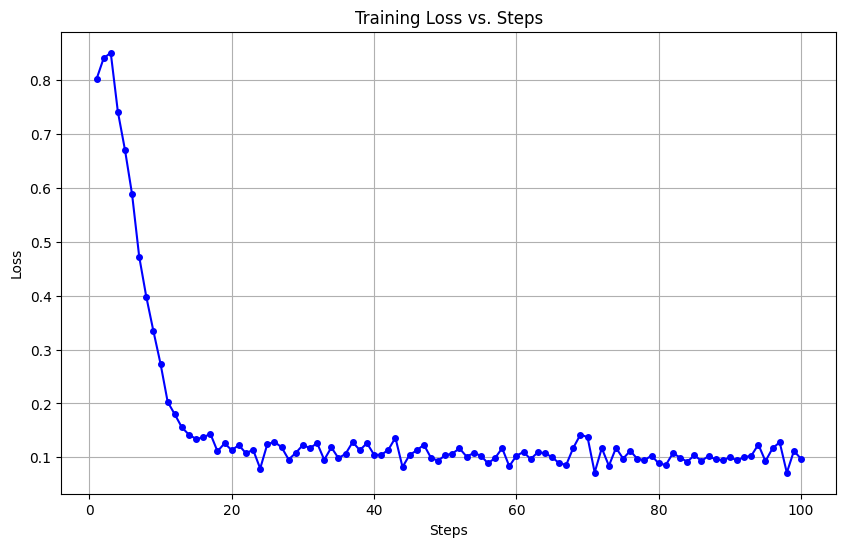

In [ ]:
import matplotlib.pyplot as plt

# Data
steps = list(range(1, 101))
losses = [
    0.801700, 0.840400, 0.850800, 0.741400, 0.670500, 0.588000, 0.472300, 0.397600, 0.334000, 0.273400,
    0.202900, 0.179700, 0.155400, 0.141900, 0.134000, 0.136800, 0.143700, 0.111200, 0.126000, 0.113100,
    0.122700, 0.107400, 0.114100, 0.079200, 0.124300, 0.128600, 0.118800, 0.095900, 0.108200, 0.122800,
    0.117100, 0.126300, 0.095400, 0.118400, 0.098400, 0.106500, 0.128300, 0.113200, 0.126300, 0.104800,
    0.104400, 0.113800, 0.136400, 0.082000, 0.104500, 0.112800, 0.123300, 0.099000, 0.093700, 0.103900,
    0.106800, 0.116700, 0.101400, 0.107800, 0.103200, 0.088900, 0.098500, 0.117000, 0.083500, 0.102800,
    0.110000, 0.096600, 0.109200, 0.107700, 0.100400, 0.089100, 0.085900, 0.117700, 0.142200, 0.137400,
    0.071800, 0.117000, 0.084200, 0.117600, 0.097500, 0.112100, 0.097000, 0.094800, 0.103100, 0.088600,
    0.085800, 0.107700, 0.099600, 0.091700, 0.103700, 0.093500, 0.102200, 0.096100, 0.094600, 0.100000,
    0.094500, 0.100200, 0.102700, 0.123700, 0.092800, 0.116800, 0.127900, 0.071400, 0.111900, 0.097100
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', linestyle='-', color='b', markersize=4)
plt.title('Training Loss vs. Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.show()